In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sensorflow_model.dataset import get_dataset


In [40]:

ACTIVITY_CLASSES = {
    0: "Sitting + Typing on Desk",
    1: "Sitting + Taking Notes", 
    2: "Standing + Writing on Whiteboard",
    3: "Standing + Erasing Whiteboard",
    4: "Sitting + Talking + Waving Hands",
    5: "Standing + Talking + Waving Hands",
    6: "Sitting + HeadNodding",
    7: "Sitting + Drinking Water",
    8: "Sitting + Drinking Coffee",
    9: "Standing + Drinking Water",
    10: "Standing + Drinking Coffee",
    11: "Scrolling on Phone",
}


In [41]:
model = load_model("../final_model.keras")

c:\Users\mohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:

# Load test data (same window size, stride as training)
def load_test_dataset(folder_path):
    X_all, y_all = [], []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            filepath = os.path.join(folder_path, file)
            X, y = get_dataset(filepath, window_size=20, stride=10, normalize=False)
            X_all.append(X)
            y_all.append(y)
    return np.concatenate(X_all), np.concatenate(y_all)

X_raw, y = load_test_dataset("../TestData/with/")


In [43]:
X_flat = X_raw.reshape((X_raw.shape[0], -1))
tsne_before = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne_before = tsne_before.fit_transform(X_flat)


In [44]:
with open("../normalization.json") as f:
    stats = json.load(f)

mean = np.array(stats["mean"])
std = np.array(stats["std"])

X_flat = X_raw.reshape(-1, X_raw.shape[-1])
X_norm = ((X_flat - mean) / std).reshape(X_raw.shape)



In [45]:
# Pad X_norm to have 200 time steps (pad at the end with zeros)
if X_norm.shape[1] < 200:
    pad_width = ((0, 0), (0, 200 - X_norm.shape[1]), (0, 0))
    X_norm_padded = np.pad(X_norm, pad_width, mode='constant')
else:
    X_norm_padded = X_norm

# Use the padded data for prediction and feature extraction
_ = model.predict(X_norm_padded[:1])

# For Sequential models, use the first layer's input as input
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

features = feature_extractor.predict(X_norm_padded, batch_size=128, verbose=1)

tsne_after = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne_after = tsne_after.fit_transform(features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


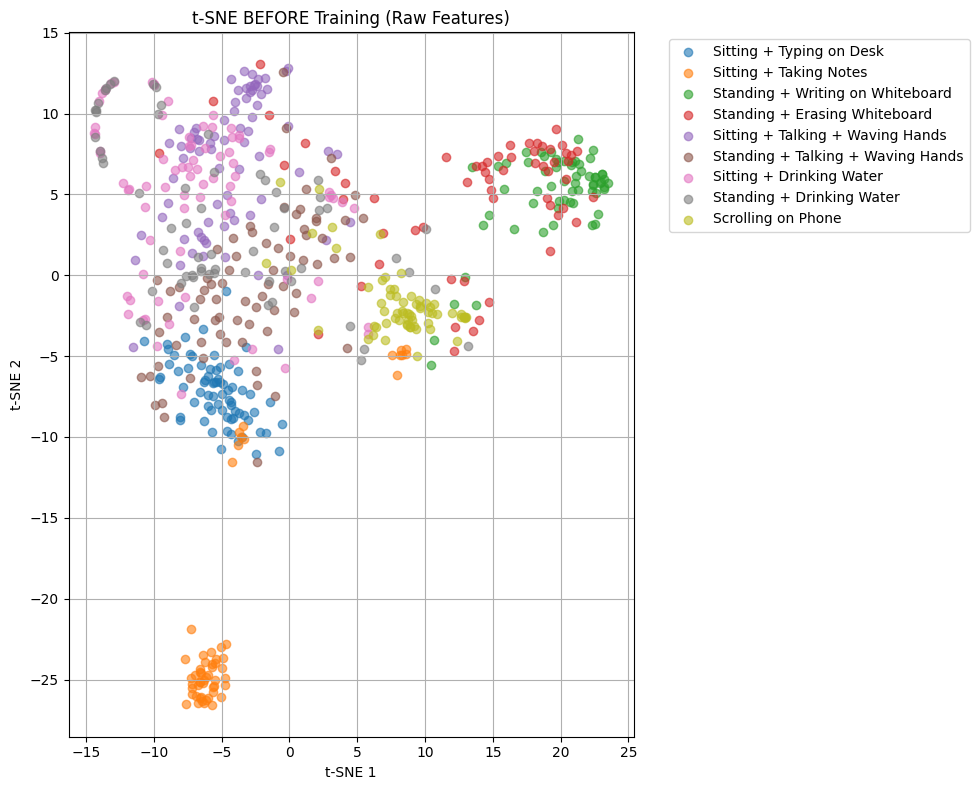

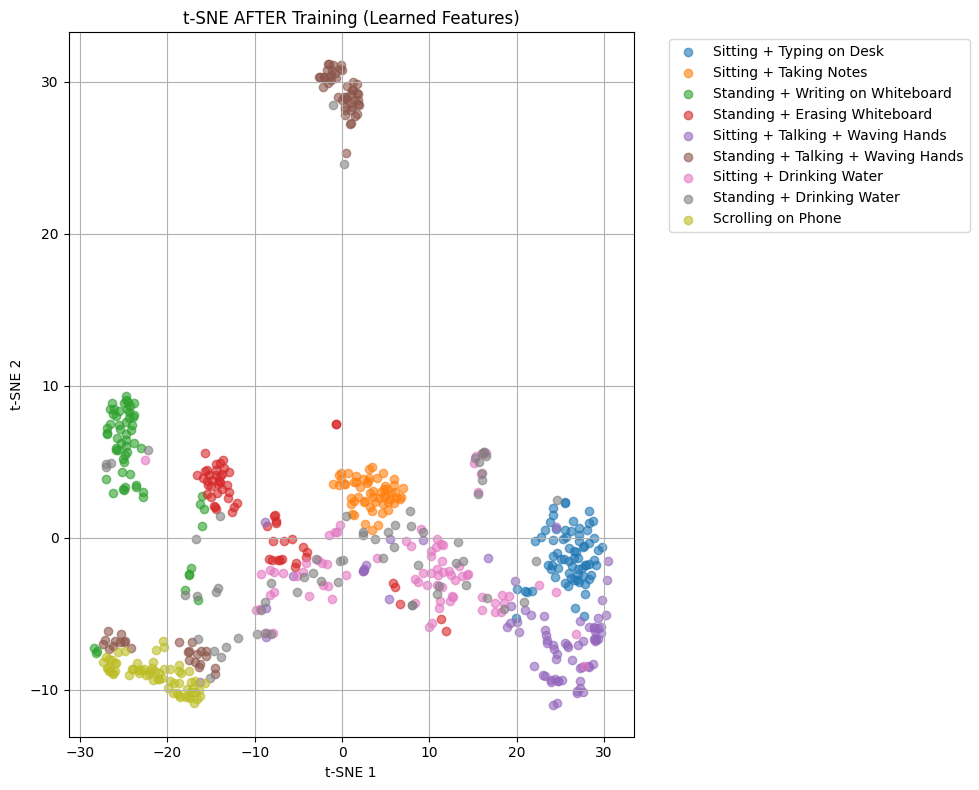

In [46]:

def plot_tsne(tsne_data, y, title):
    plt.figure(figsize=(10, 8))
    for label in np.unique(y):
        idxs = y == label
        plt.scatter(tsne_data[idxs, 0], tsne_data[idxs, 1], label=ACTIVITY_CLASSES.get(label, str(label)), alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_tsne(X_tsne_before, y, "t-SNE BEFORE Training (Raw Features)")
plot_tsne(X_tsne_after, y, "t-SNE AFTER Training (Learned Features)")


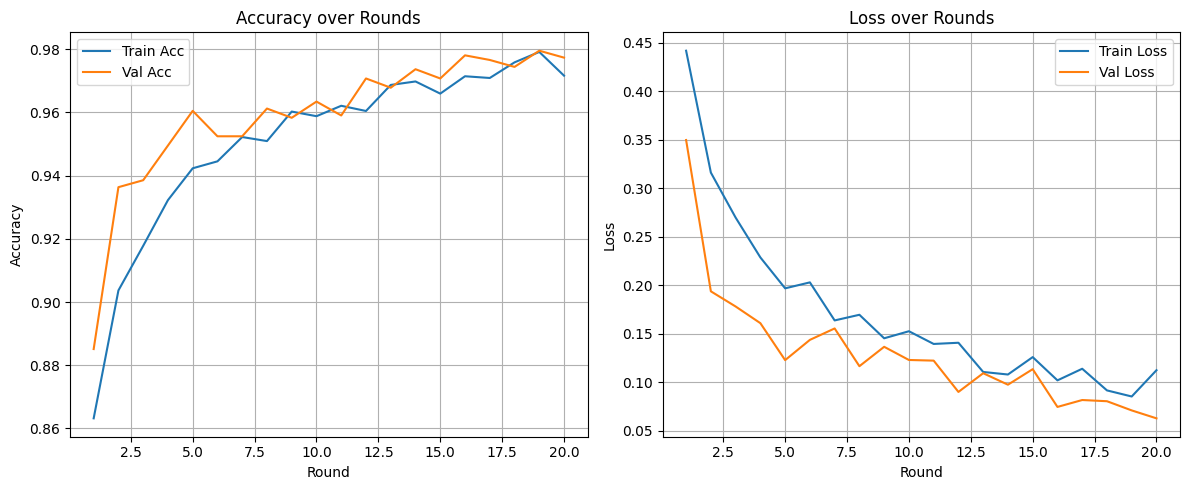

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = "../metrics_over_rounds.csv"
if not os.path.exists(csv_path):
	print(f"File not found: {csv_path}")
else:
	df = pd.read_csv(csv_path)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df["round"], df["train_accuracy"], label="Train Acc")
plt.plot(df["round"], df["val_accuracy"], label="Val Acc")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Accuracy over Rounds")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df["round"], df["train_loss"], label="Train Loss")
plt.plot(df["round"], df["val_loss"], label="Val Loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss over Rounds")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


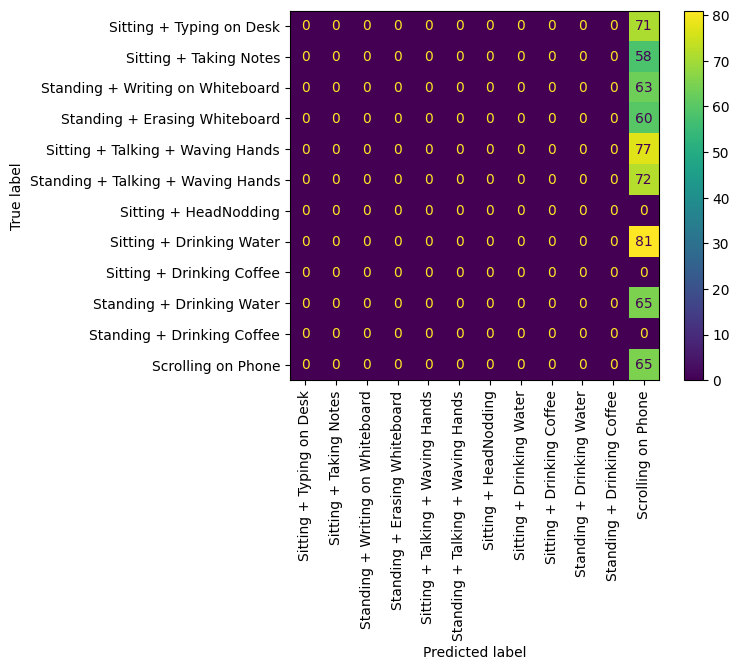

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_norm_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
class_indices = list(ACTIVITY_CLASSES.keys())
ConfusionMatrixDisplay.from_predictions(
	y, y_pred_labels,
	labels=class_indices,
	display_labels=list(ACTIVITY_CLASSES.values()),
	xticks_rotation=90
)


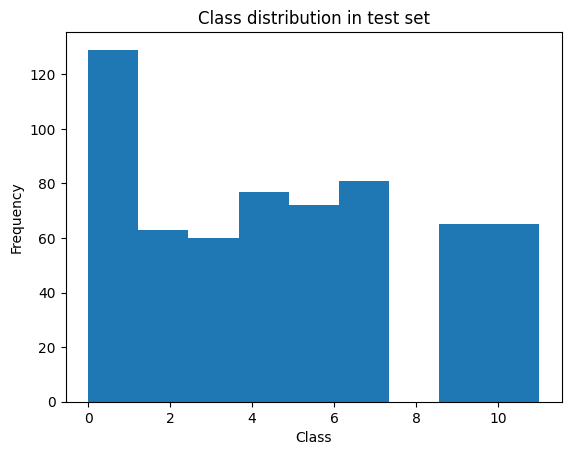

In [49]:
plt.hist(y, bins=len(np.unique(y)))
plt.title("Class distribution in test set")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
